In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from sklearn.metrics.pairwise import euclidean_distances
import math
from scipy.spatial import ConvexHull
import torch
import itertools


def plot_triangulation (points, triang):
    plt.triplot (points[:,0], points[:,1], triang)
    plt.plot (points[:,0], points[:,1], 'o')
    plt.show()

def calc_L(points, simplices):
    #simplices = Delaunay (points).simplices
    #distances = euclidean_distances (points, points)
    
    L = torch.zeros((len(points), len(points)))

    for sim in simplices:
        for ind in [[0, 1], [1, 2], [0, 2]]:
            #L [sim [ind [0]], sim [ind [1]]] = distances [sim [ind [0]], sim [ind [1]]]
            #L [sim [ind [1]], sim [ind [0]]] = distances [sim [ind [1]], sim [ind [0]]]
            L [sim [ind [0]], sim [ind [1]]] = ((points[sim [ind [0]]][0]-points[sim [ind [1]]][0])**2+\
                                               (points[sim [ind [0]]][1]-points[sim [ind [1]]][1])**2)**0.5
            L [sim [ind [1]], sim [ind [0]]] = ((points[sim [ind [0]]][0]-points[sim [ind [1]]][0])**2+\
                                               (points[sim [ind [0]]][1]-points[sim [ind [1]]][1])**2)**0.5

    return L

def calc_triangle_area(L, i1, i2, i3):
    l1 = L [i1, i2]
    l2 = L [i2, i3]
    l3 = L [i3, i1]

    p = (l1 + l2 + l3) / 2

    return torch.sqrt(p * (p - l1) * (p - l2) * (p - l3))

def calc_A (simplices, L, points_num):
    A = torch.zeros ((points_num, points_num))
    
    for i in range (points_num):
        area = 0
        
        for j in range (len (simplices)):
            if (i in simplices [j]):
                sim = simplices [j]
                
                area_part = calc_triangle_area (L, sim [0], sim [1], sim [2])
                
                area += area_part / 3
        
        A [i, i] = area
    
    return A

def find_E_Eb (points, simplices):
    E = []
    
    for sim in simplices:
        E.append (sorted ((sim [0], sim [1])))
        E.append (sorted ((sim [1], sim [2])))
        E.append (sorted ((sim [2], sim [0])))
    
    E_b = []
    hull = ConvexHull (points).vertices
    
    for i in range (len (hull) - 1):
        E_b.append (sorted ((hull [i], hull [i + 1])))
    
    E_b.append (sorted ((hull [0], hull [-1])))
    
    #АЛАРМА
    #Тут нужно оставить в E и E_b только уникальные таплы.
    #Я попробовал это сделать, но с unhashable type какая-то морока, так то я забил.
    #В этом месте числа внутри тапла отсортированы.
    #Пробовал вот таким образом:
    #return list (set (E)), list (set (E_b))
    
    return E, E_b

def calc_W (E, E_b, A, L, simplices):
    W = torch.zeros (A.shape)
    
    sh = W.shape
    
    for i in range (sh [0]):
        for j in range (i + 1, sh [0]):
            kh_list = []
    
            for sim in simplices:
                elem = set (sim)                
                ele = set ([i, j])
                
                #print ("ele, elem")
                #print (ele, elem)
                
                if (ele.issubset (elem)):
                    kh_list.append (elem.difference (ele))
            
            if (len (kh_list) == 0):
                continue
            
            h = list (kh_list [0]) [0]
            
            if ([i, j] in E and [i, j] not in E_b):
                k = list (kh_list [1]) [0]
                
                val = 0
                
                val += (- L [i, j]**2 + L [j, k]**2 + L [k, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, k))

                val += (- L [i, j]**2 + L [j, h]**2 + L [h, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, h))
                
                W [i, j] = val
                
            elif ([i, j] in E_b):
                val = 0
                
                val += (- L [i, j]**2 + L [j, h]**2 + L [h, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, h))
                
                W [i, j] = val
        
    for i in range (sh [0]):
        for j in range (i, sh [0]):
            W [j] [i] = W [i] [j]
    
    for i in range (sh [0]):
        W [i, i] = - torch.sum (W [i, :])

    return W

def modified_gram_schmidt_qr(A): # 5 pts
    assert A.shape[0] >= A.shape[1], 'm is not >= n'
    new_vectors = torch.zeros(A.shape)
    for i in range(A.shape[1]):
        new_vectors[:,i] += A[:,i]
        if i > 0:
            tmp = torch.tensor(new_vectors[:,0])
            new_vectors[:,i] -= ((A[:,i] @ tmp)/(tmp @ tmp)) * tmp
        
        for j in range(1,i):
            tmp1 = torch.tensor(new_vectors[:,i])
            tmp2 = torch.tensor(new_vectors[:,j])
            new_vectors[:,i] -= ((tmp1 @ tmp2)/(tmp2 @ tmp2)) * tmp2
        
    # normalization
    for i in range(new_vectors.shape[1]):
        tmp3 = torch.tensor(new_vectors[:,i])
        new_vectors[:,i] /= torch.tensor(tmp3).norm()
    Q = new_vectors
    R = torch.zeros((A.shape[1],A.shape[1]))
    for i in range(A.shape[1]):
        for j in range(i, A.shape[1]):
            R[i,j] += A[:,j] @ new_vectors[:,i]
    return Q, R

def qralgo(a):
    while torch.sqrt(torch.sum(a.tril(-1)-1)) > 1e-9: 
        q,r = modified_gram_schmidt_qr(a) 
        a = r @ q
    return a

def eigvals(a):
    return qralgo(a).diag()


def find_eigenvalues (W, A):
    product = torch.inverse (A) @ W
    
    #lambdas, vectors = tuple (torch.symeig (product, eigenvectors=True))
    lambdas = eigvals(product)
    
    return torch.sort(lambdas)[0]

def cut (val):
    return (torch.min (torch.tensor(0.), val))**2

def rho (V, L, E_b, simplices):
    rho_1 = torch.tensor(0.0)
    
    for e in E_b:
        rho_1 += L [e [0], e [1]]**2
    
    rho_2 = torch.tensor(0.0)
    
    for s in simplices:
        for sim in list(itertools.permutations(s)):

            rot_matr = torch.tensor ([[0., -1.], [1., 0.]])
            sub_1 = V [sim [1]] - V [sim [0]]
            sub_2 = V [sim [2]] - V [sim [0]]

            curr_val = (rot_matr @ sub_1) @ sub_2

            rho_2 += curr_val

    rho = rho_1 + cut (rho_2)
    
    return rho

def weighted_norm (a, b):
    norm = 0.0
    
    for i in range (len (a)):
        norm += (a [i] - b [i])**2 / (i + 1)
    
    return norm



In [131]:
xc = 0.0
yc = 0.0
R = 3
xs = np.random.uniform(-1,1, 20)
ys = np.random.uniform(-1,1, 20)
target = list(zip(xc+xs, yc+ys))

In [132]:
#target = [(0.0, 0.0), (1.0, 0.0), (2.0, 1.0), (0.0, 1.0)]
tri = Delaunay(target)
simplices = tri.simplices
E, E_b = find_E_Eb (target, simplices)
target_points = torch.tensor(target)
L = calc_L(target_points, simplices)
A = calc_A(simplices, L, len (target_points))
W = calc_W(E, E_b, A, L, simplices)
mu = find_eigenvalues(W, A)

/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:155: UserWarning: To copy con

In [134]:
mu

tensor([-9.6923e+02, -8.6743e+02, -3.9051e+02, -1.9724e+02, -9.6624e+01,
        -7.8890e+01, -4.1004e+01, -3.9642e+01, -3.9366e+01, -3.3602e+01,
        -3.2555e+01, -3.2197e+01, -2.8773e+01, -2.2784e+01, -1.3221e+01,
        -1.1427e+01, -6.8979e+00, -3.7404e+00, -3.1844e-01, -2.5670e-01])

In [135]:
#initial = [(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0)]

xc = 0.0
yc = 0.0
R = 3
xs = np.random.uniform(-1,1, 20)
ys = np.random.uniform(-1,1, 20)
initial = list(zip(xc+xs, yc+ys))

tri = Delaunay(initial)
simplices = tri.simplices
E, E_b = find_E_Eb (initial, simplices)

points = torch.tensor(initial, requires_grad=True)
optimizer = torch.optim.Adam([points], lr = 0.001)

print("Target: {}".format(mu))

for _ in range(10000):
    L = calc_L (points, simplices)
    A = calc_A (simplices, L, len (points))
    W = calc_W (E, E_b, A, L, simplices)
    pen = rho (points, L, E_b, simplices)
    
    current_eigen = find_eigenvalues(W, A)
    
    #loss =   weighted_norm(current_eigen, mu)+pen# calculate loss
    loss =   weighted_norm(current_eigen, mu)# calculate loss
    #print (mu)
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients of all variables wrt loss

    optimizer.step()
    if _ % 25 == 0:
        #print(current_eigen)
        #print(loss, current_eigen, pen)
        print(loss)
    

Target: tensor([-9.6923e+02, -8.6743e+02, -3.9051e+02, -1.9724e+02, -9.6624e+01,
        -7.8890e+01, -4.1004e+01, -3.9642e+01, -3.9366e+01, -3.3602e+01,
        -3.2555e+01, -3.2197e+01, -2.8773e+01, -2.2784e+01, -1.3221e+01,
        -1.1427e+01, -6.8979e+00, -3.7404e+00, -3.1844e-01, -2.5670e-01])


/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dmitriy/MyEnv/other/skoltech/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:155: UserWarning: To copy con

tensor(193548.7031, grad_fn=<AddBackward0>)
tensor(56087.0234, grad_fn=<AddBackward0>)
tensor(60538.3516, grad_fn=<AddBackward0>)
tensor(60901.2812, grad_fn=<AddBackward0>)
tensor(60971.5352, grad_fn=<AddBackward0>)
tensor(60918.4336, grad_fn=<AddBackward0>)
tensor(60764.1367, grad_fn=<AddBackward0>)
tensor(61157.1719, grad_fn=<AddBackward0>)
tensor(60694.0625, grad_fn=<AddBackward0>)
tensor(60690.6055, grad_fn=<AddBackward0>)
tensor(60140.3672, grad_fn=<AddBackward0>)
tensor(60007.3906, grad_fn=<AddBackward0>)
tensor(59641.7852, grad_fn=<AddBackward0>)
tensor(59570.4727, grad_fn=<AddBackward0>)
tensor(59781.0859, grad_fn=<AddBackward0>)
tensor(59876.0039, grad_fn=<AddBackward0>)
tensor(59606.2891, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [123]:
points

tensor([[-0.1742,  0.0100],
        [ 1.1403, -0.3057],
        [ 1.1154,  1.1378],
        [-0.2706,  1.1079]], requires_grad=True)

In [117]:
target_points

tensor([[0., 0.],
        [1., 0.],
        [2., 1.],
        [0., 1.]])

In [65]:
current_eigen

tensor([-6.0298, -3.3460, -2.8026, -2.6982], grad_fn=<SortBackward>)

In [22]:
points

tensor([[0.1802, 0.1802],
        [0.8048, 0.1944],
        [0.8625, 0.8239],
        [0.1478, 0.8092]], requires_grad=True)

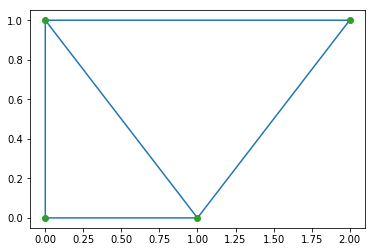

In [124]:
plot_triangulation(target_points.detach().numpy(), simplices)

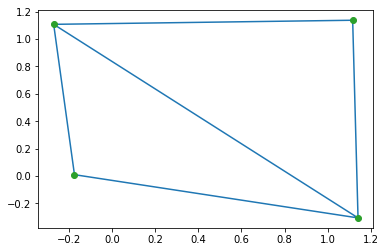

In [125]:
plot_triangulation(points.detach().numpy(), simplices)

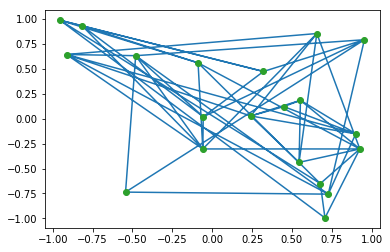

In [136]:
plot_triangulation(target_points.detach().numpy(), simplices)

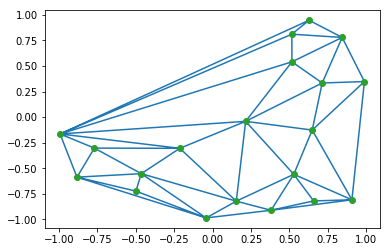

In [137]:
plot_triangulation(points.detach().numpy(), simplices)

In [75]:
tri.simplices

array([[2, 3, 1],
       [1, 3, 0]], dtype=int32)

In [28]:
mu

tensor([-3.7500, -2.2000, -1.6667, -0.7000])